In [1]:
#Se importan las librerías básicas para manejo de datos y generación de gráficos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Como complemento, se importan los elementos de la librería Plotly, que permite general gráficos de alto nivel de detalle y los despliega en formato html
import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.tools as tls                             
import plotly as plot
from collections import Counter                 
import plotly.figure_factory as ff

#Por último, se importan las librerías dedicadas al preprocesamiento de los datos, los modelos a usar para la implementación de algoritmos de aprendizaje
#supervisado y las métricas de evaluación
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

In [2]:
datos = pd.read_excel(r"C:\Users\jlope\Documents\Prueba_tecnica_Tuya\ProductoNuevo.xlsx") # Carga de los datos de forma local desde el archivo excel. 
datos = datos.drop(columns=['ID','FFECHA']) #Se eliminan las columnas 'ID' y 'FFECHA', pues aportan información relevante al modelo.
datos.index = np.arange(1, len(datos) + 1) #Se modifica la numeración del Índice del conjunto de datos, de modo que inicie en el número 1.
datos.head()

,Mora30,Mora60,MoraMax_UltimoSemestre,Experiencia,PersonasCargo,GastosFamiliares,GastoArriendo,TiempoActividad,OCUPACION,TIPCONTRATO,Edad,Estado_Civil,Genero,Ingresos,Nivel_Academico,Tipo_Vivienda,TiempoCliente,Tiempo_SistemaFro,PORCEND,Obligaciones_SistemaFro
1,0,0,0,0,0,7837.87,0,10,JUBILADOS/PENSIONADO,TÉRMINO INDEFINIDO,61,CASADO,MASCULINO,11698.313433,TECNÓLOGO,PROPIA,40,0,1.020685,0
2,1,0,59,0,1,9194.07,0,1,EMPLEADO,TÉRMINO INDEFINIDO,45,CASADO,FEMENINO,13722.492537,TECNÓLOGO,ALQUILADA,0,0,0.543829,0
3,0,0,30,1,1,8450.00,0,1,EMPLEADO,TÉRMINO FIJO,55,CASADO,MASCULINO,12611.940299,BACHILLER,PROPIA,13,73,0.946746,0
4,1,0,47,0,0,7472.00,0,1,EMPLEADO,TÉRMINO FIJO,35,SOLTERO,MASCULINO,11152.238806,UNIVERSITARIO,FAMILIAR,1,0,0.936831,0
5,0,0,0,0,0,6160.00,0,2,EMPLEADO,TÉRMINO FIJO,58,SOLTERO,MASCULINO,9194.029851,UNIVERSITARIO,FAMILIAR,0,0,0.487013,0


In [3]:
datos.info()  #Se imprime la información general y se verifica si existen datos nulos en el conjunto de datos.
datos.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4315 entries, 1 to 4315
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mora30                   4315 non-null   int64  
 1   Mora60                   4315 non-null   int64  
 2   MoraMax_UltimoSemestre   4315 non-null   int64  
 3   Experiencia              4315 non-null   int64  
 4   PersonasCargo            4315 non-null   int64  
 5   GastosFamiliares         4315 non-null   float64
 6   GastoArriendo            4315 non-null   int64  
 7   TiempoActividad          4315 non-null   int64  
 8   OCUPACION                4315 non-null   object 
 9   TIPCONTRATO              4315 non-null   object 
 10  Edad                     4315 non-null   int64  
 11  Estado_Civil             4315 non-null   object 
 12  Genero                   4315 non-null   object 
 13  Ingresos                 4315 non-null   float64
 14  Nivel_Academico         

Mora30                     0
Mora60                     0
MoraMax_UltimoSemestre     0
Experiencia                0
PersonasCargo              0
GastosFamiliares           0
GastoArriendo              0
TiempoActividad            0
OCUPACION                  0
TIPCONTRATO                0
Edad                       0
Estado_Civil               0
Genero                     0
Ingresos                   0
Nivel_Academico            0
Tipo_Vivienda              0
TiempoCliente              0
Tiempo_SistemaFro          0
PORCEND                    0
Obligaciones_SistemaFro    0
dtype: int64

In [4]:
datos.nunique() #Se observa el número de registros únicos por columna.

Mora30                        2
Mora60                        2
MoraMax_UltimoSemestre       88
Experiencia                   2
PersonasCargo                 7
GastosFamiliares           1270
GastoArriendo                29
TiempoActividad              35
OCUPACION                     2
TIPCONTRATO                   7
Edad                         52
Estado_Civil                  5
Genero                        2
Ingresos                   1298
Nivel_Academico               5
Tipo_Vivienda                 3
TiempoCliente               130
Tiempo_SistemaFro           153
PORCEND                    1551
Obligaciones_SistemaFro       5
dtype: int64

Se modifica la variable de Edad, pasando esta de ser una variable numérica a una categórica. Para ello, se toma como referencia las disposiciones sobre grupos de edad del Ministerio de Salud de Colombia, sin embargo, se extiende el rango de edad de los Jóvenes de 26 a 28 para obtener una escala más equilibrada, y además, apoyándose en programas de gobierno como "El Pacto Colombia con las Juventudes", que adopta este rango de edad. 

In [5]:
Edad = []                               # Se aplica un ciclo For para ajustar los rangos de edad, quedando así tres variables:
for x in datos['Edad']:
  if x >= 60:
    Edad.append('Adulto mayor (>60)')    # Adulto mayor: Para las personas mayores de 60 años.
  elif x >= 29:
    Edad.append('Adulto (29-59)')        # Adulto: Para el rango de edad de 29 a 59 años.
  elif x >= 18:
    Edad.append('Joven (18-28)')         # Joven: Para el rango de edad de 18 a 28 años.
  else:
    None 

In [6]:
datos = datos.drop(columns=['Edad'])    # Se elimina la columna antigua Edad para ser reemplazada por la variable categórica creada en la celda anterior.
datos.insert(9, "Edad", Edad, allow_duplicates=False)
datos.head()

,Mora30,Mora60,MoraMax_UltimoSemestre,Experiencia,PersonasCargo,GastosFamiliares,GastoArriendo,TiempoActividad,OCUPACION,Edad,TIPCONTRATO,Estado_Civil,Genero,Ingresos,Nivel_Academico,Tipo_Vivienda,TiempoCliente,Tiempo_SistemaFro,PORCEND,Obligaciones_SistemaFro
1,0,0,0,0,0,7837.87,0,10,JUBILADOS/PENSIONADO,Adulto mayor (>60),TÉRMINO INDEFINIDO,CASADO,MASCULINO,11698.313433,TECNÓLOGO,PROPIA,40,0,1.020685,0
2,1,0,59,0,1,9194.07,0,1,EMPLEADO,Adulto (29-59),TÉRMINO INDEFINIDO,CASADO,FEMENINO,13722.492537,TECNÓLOGO,ALQUILADA,0,0,0.543829,0
3,0,0,30,1,1,8450.00,0,1,EMPLEADO,Adulto (29-59),TÉRMINO FIJO,CASADO,MASCULINO,12611.940299,BACHILLER,PROPIA,13,73,0.946746,0
4,1,0,47,0,0,7472.00,0,1,EMPLEADO,Adulto (29-59),TÉRMINO FIJO,SOLTERO,MASCULINO,11152.238806,UNIVERSITARIO,FAMILIAR,1,0,0.936831,0
5,0,0,0,0,0,6160.00,0,2,EMPLEADO,Adulto (29-59),TÉRMINO FIJO,SOLTERO,MASCULINO,9194.029851,UNIVERSITARIO,FAMILIAR,0,0,0.487013,0


Previo a la construcción de los modelos, se realiza un pequeño análisis de Estadística Descriptiva, donde se observa la relación de algunas de sus variables y hacer inferencias a partir de ellas. La primera gráfica analiza la relación entre los clientes que presentaron una mora mayor de 30 días, y aquellos que no; lo propio se hace con aquellos que presentaron una mora mayor a 60 días. De este modo, podemos observar que pasados 60 días, poco más de la mitad de personas que presentaban mora después de 30 días ya se habían puesto al día con sus obligaciones, lo que en principio es una buena señal. Sin embargo, al tratarse de un producto de alta gama, se desaconseja considerar a aquellos que presentaron más de 30 días de mora, por lo que se asume este último como el criterio de evaluación para los modelos de clasificación.

In [7]:
barra0 = go.Bar(
            x = datos[datos["Mora30"]== 0]["Mora30"].value_counts().index.values,
            y = datos[datos["Mora30"]== 0]["Mora30"].value_counts().values,
            name='Sin Mora')

barra1 = go.Bar(
            x = datos[datos["Mora30"]== 1]["Mora30"].value_counts().index.values,
            y = datos[datos["Mora30"]== 1]["Mora30"].value_counts().values,
            name='Con Mora')

barra2 = go.Bar(
            x = datos[datos["Mora60"]== 0]["Mora60"].value_counts().index.values,
            y = datos[datos["Mora60"]== 0]["Mora60"].value_counts().values,
            name='Sin Mora')

barra3 = go.Bar(
            x = datos[datos["Mora60"]== 1]["Mora60"].value_counts().index.values,
            y = datos[datos["Mora60"]== 1]["Mora60"].value_counts().values,
            name='Con Mora')


data = [barra0, barra1, barra2, barra3]

fig = plot.subplots.make_subplots(rows=1, cols=2, subplot_titles=('30 días','60 días'))

fig.append_trace(barra0, 1, 1)
fig.append_trace(barra1, 1, 1)
fig.append_trace(barra2, 1, 2)
fig.append_trace(barra3, 1, 2)

fig['layout'].update(showlegend=True, yaxis=dict(
        title='Frecuencia'
    ),
    title='Comparativa Tiempo de Mora', bargap=0.05)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
fig.data[2].marker.line.width = 4
fig.data[2].marker.line.color = "black"
fig.data[3].marker.line.width = 4
fig.data[3].marker.line.color = "black"
py.iplot(fig, filename='Comparativa_Tiempo_de_Mora')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

Para la relación entre los ingresos y edad del cliente con una mora máxima de 30 días, encontramos que su distribución es muy similar en los tres grupos de edad, incluso la mediana en jóvenes, adultos y adultos mayores que presentan una mora mayor a 30 días, se ubica entre 10 mil y 10500. Por su parte, observamos una distribución intercuartil con poca variación entre los tres casos, que se evidencia en la semejanza en el tamaño de la caja; sin embargo, se observa una ligera variación para los adultos mayores, pues su valor máximo (13432) se ubica por debajo de los demás grupos de edad.

In [8]:
caja0 = go.Box(
    y=datos[datos['Mora30'] == 0]['Ingresos'],
    x=datos[datos['Mora30'] == 0]['Edad'],
    name='Sin Mora',
    )

caja1 = go.Box(
    y=datos[datos['Mora30'] == 1]['Ingresos'],
    x=datos[datos['Mora30'] == 1]['Edad'],
    name='Con Mora',
    )
    
data = [caja0, caja1]

layout = go.Layout(
    yaxis=dict(
        title='Ingresos por grupos de edad',
        zeroline=False
    ),
    xaxis=dict(
        title='Grupos de Edad'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Edad-Box')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

En los dos gráficos siguientes, se observa la relación entre el nivel de ingreso y los gatos totales con los días de mora máximos en el Último semestre. Para los gastos totales, se sumaron las variables 'GastosFamiliares' y 'GastoArriendo'. Frente a los gastos, encontramos que existe una relación inversa entre las variables, pues existe una alta concentración de clientes con Gastos elevados que poseen pocos días de mora en la Base de Datos; Por el contrario, las personas que presentan más de 100 días de mora en la generalidad reportan gastos bajos, con algunas excepciones que representan datos atípicos. La relación entre la variable Ingesos y Mora Máxima, por su parte, presenta una distribución equilibrada de los datos, y no presenta alta concentración en un rango específico; sin embargo, entre el extremo derecho en donde se ubican las personas con más días de mora reportados, si se observa una tendencia a la baja en relación al nivel de ingresos.

In [9]:
linea0 = go.Scatter(
    x=datos['MoraMax_UltimoSemestre'],
    y=datos['GastosFamiliares'] + datos['GastoArriendo'],
    mode='markers',
    name='Gastos Totales')

linea1 = go.Scatter(
    x=datos['MoraMax_UltimoSemestre'],
    y=datos['Ingresos'],
    mode='markers',
    name='Ingresos')

fig = plot.subplots.make_subplots(rows=2, cols=1, subplot_titles=('Mora Máxima por Gastos Totales','Mora Máxima por Ingresos'))

fig.append_trace(linea0,1,1)
fig.append_trace(linea1,2,1)

py.iplot(fig, filename='Gastos-Ingresos')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

In [10]:
SinMora = datos[datos["Mora30"]== 0]
ConMora = datos[datos["Mora30"]== 1]

barra0 = go.Bar(
            x = SinMora['TIPCONTRATO'].value_counts().index.values,
            y = SinMora['TIPCONTRATO'].value_counts().values,
            name='Sin Mora')

barra1 = go.Bar(
            x = ConMora['TIPCONTRATO'].value_counts().index.values,
            y = ConMora['TIPCONTRATO'].value_counts().values,
            name='Con Mora')

caja0 = go.Box(
    y=datos[datos['Mora30'] == 0]['Ingresos'],
    x=datos[datos['Mora30'] == 0]['TIPCONTRATO'],
    name='Sin Mora',
    )

caja1 = go.Box(
    y=datos[datos['Mora30'] == 1]['Ingresos'],
    x=datos[datos['Mora30'] == 1]['TIPCONTRATO'],
    name='Con Mora',
    )
    
data = [barra0, barra1, caja0, caja1]

fig = plot.subplots.make_subplots(rows=2, cols=1, subplot_titles=('Distribución por Tipo de Contrato','Nivel de ingresos por Tipo de Contrato'))

fig.append_trace(barra0, 1, 1)
fig.append_trace(barra1, 1, 1)
fig.append_trace(caja0, 2, 1)
fig.append_trace(caja1, 2, 1)

fig['layout'].update(height=800,boxmode='group')

py.iplot(fig, filename='Tipo_Contrato')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

In [11]:
barra0 = go.Bar(
            x = SinMora['Tipo_Vivienda'].value_counts().index.values,
            y = SinMora['Tipo_Vivienda'].value_counts().values,
            name='Sin Mora')

barra1 = go.Bar(
            x = ConMora['Tipo_Vivienda'].value_counts().index.values,
            y = ConMora['Tipo_Vivienda'].value_counts().values,
            name='Con Mora')

barra2 = go.Bar(
            x = SinMora['Nivel_Academico'].value_counts().index.values,
            y = SinMora['Nivel_Academico'].value_counts().values,
            name='Sin Mora')

barra3 = go.Bar(
            x = ConMora['Nivel_Academico'].value_counts().index.values,
            y = ConMora['Nivel_Academico'].value_counts().values,
            name='Con Mora')

barra4 = go.Bar(
            x = SinMora['Estado_Civil'].value_counts().index.values,
            y = SinMora['Estado_Civil'].value_counts().values,
            name='Sin Mora')

barra5 = go.Bar(
            x = ConMora['Estado_Civil'].value_counts().index.values,
            y = ConMora['Estado_Civil'].value_counts().values,
            name='Con Mora')
    
data = [barra0, barra1, barra2, barra3, barra4, barra5]

fig = plot.subplots.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]], subplot_titles=('Distribución por Tipo de Vivienda','Distribución por Nivel Académico', 'Distribución por Estado Civil'))

fig.append_trace(barra0, 1, 1)
fig.append_trace(barra1, 1, 1)
fig.append_trace(barra2, 1, 2)
fig.append_trace(barra3, 1, 2)
fig.append_trace(barra4, 2, 1)
fig.append_trace(barra5, 2, 1)

fig['layout'].update(height=800)

py.iplot(fig, filename='Vivienda_NivelAcademico_EstadoCivil')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

In [12]:
linea0 = go.Scatter(
    x=SinMora['Tiempo_SistemaFro'],
    y=SinMora['TiempoCliente'],
    mode='markers',
    name='Sin Mora')

linea1 = go.Scatter(
    x=ConMora['Tiempo_SistemaFro'],
    y=ConMora['TiempoCliente'],
    mode='markers',
    name='Con Mora')

fig = plot.subplots.make_subplots(rows=2, cols=1, subplot_titles=('Tiempo en el Sistema Financiero por el Tiempo del Cliente','Tiempo en el Sistema Financiero por el Tiempo del Cliente'))

fig.append_trace(linea0,1,1)
fig.append_trace(linea1,2,1)

fig['layout'].update(height=800)
py.iplot(fig, filename='Tiempos_Sistema')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

In [13]:
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.int64) #Se transforman los datos contenidos en las variables categóricas a una escala numérica, de modo que no presente
                                                                    #problemas de entrada a los algoritmos.
ordinalEncoder.fit(datos[['OCUPACION','TIPCONTRATO','Estado_Civil','Edad','Genero','Nivel_Academico','Tipo_Vivienda']])

datos[['OCUPACION','TIPCONTRATO','Estado_Civil','Edad','Genero','Nivel_Academico','Tipo_Vivienda']] = ordinalEncoder.transform(datos[['OCUPACION','TIPCONTRATO','Estado_Civil','Edad','Genero','Nivel_Academico','Tipo_Vivienda']])
datos

,Mora30,Mora60,MoraMax_UltimoSemestre,Experiencia,PersonasCargo,GastosFamiliares,GastoArriendo,TiempoActividad,OCUPACION,Edad,TIPCONTRATO,Estado_Civil,Genero,Ingresos,Nivel_Academico,Tipo_Vivienda,TiempoCliente,Tiempo_SistemaFro,PORCEND,Obligaciones_SistemaFro
1,0,0,0,0,0,7837.87,0,10,1,1,6,0,1,11698.313433,3,2,40,0,1.020685,0
2,1,0,59,0,1,9194.07,0,1,0,0,6,0,0,13722.492537,3,0,0,0,0.543829,0
3,0,0,30,1,1,8450.00,0,1,0,0,5,0,1,12611.940299,0,2,13,73,0.946746,0
4,1,0,47,0,0,7472.00,0,1,0,0,5,3,1,11152.238806,4,1,1,0,0.936831,0
5,0,0,0,0,0,6160.00,0,2,0,0,5,3,1,9194.029851,4,1,0,0,0.487013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1,1,170,0,0,6160.00,0,1,0,2,6,3,0,9194.029851,3,1,0,0,0.487013,0
4312,1,1,77,0,0,6160.27,0,2,0,2,3,3,0,9194.432836,4,1,16,0,0.973983,0
4313,1,1,76,0,0,6160.00,0,1,0,2,3,3,0,9194.029851,0,1,0,0,0.487013,0
4314,0,0,0,0,0,8200.00,0,1,0,2,6,3,0,12238.805970,3,1,11,0,0.975610,0


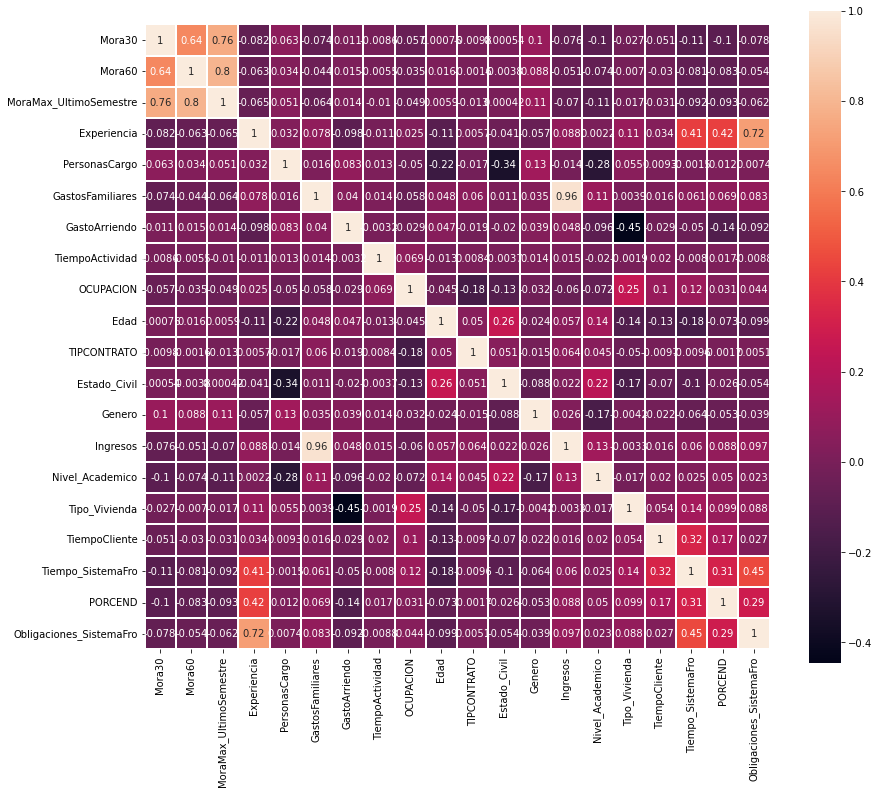

In [14]:
plt.figure(figsize=(14,12))
sns.heatmap(datos.astype(float).corr(),linewidths=0.1,vmax=1.0,  #Matriz de correlación graficada
            square=True,  linecolor='white', annot=True)
plt.show()

In [15]:
X = np.array(datos.drop(['Mora30','Mora60'],1)) # Definición de las variables predictoras (X) y las variables dependientes (Y)
Y = np.array(datos['Mora30'])  # Se elige la variable 'Mora30' para realizar las predicciones.
feature_names = datos.drop(['Mora30','Mora60'],1)
feature_names = feature_names.columns #Se abstraen los nombres de las columnas en un array de numpy para efectos de graficación, en donde se mantengan dichos nombres.
feature_names = np.array(feature_names)
feature_names

C:\Users\jlope\AppData\Local\Temp/ipykernel_3616/1273163343.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\jlope\AppData\Local\Temp/ipykernel_3616/1273163343.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



array(['MoraMax_UltimoSemestre', 'Experiencia', 'PersonasCargo',
       'GastosFamiliares', 'GastoArriendo', 'TiempoActividad',
       'OCUPACION', 'Edad', 'TIPCONTRATO', 'Estado_Civil', 'Genero',
       'Ingresos', 'Nivel_Academico', 'Tipo_Vivienda', 'TiempoCliente',
       'Tiempo_SistemaFro', 'PORCEND', 'Obligaciones_SistemaFro'],
      dtype=object)

In [16]:
X = pd.DataFrame(X, columns=feature_names)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234) #Particionamiento de los datos

In [18]:
escalar = StandardScaler(with_mean=False) #Escalamiento de los datos con StandarScaler
X_train = escalar.fit_transform(X_train)
X_test = escalar.transform(X_test)

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True) #Se define la función StratifiedKFold para realizar Cross Validation

A continuación, se contruyen y se compara el rendimiento de 5 modelos de clasificación. Además, se utiliza la función GridSearchCV para encontrar la combinación de los mejores hiperparámetros para nuestro conjunto de datos, y, en consecuencia, el modelo óptimo. Los modelos desplegados fueron Regresión Logística, Random Forest, Support Vector Machine, K-Nearest Neighbors y Linear Discriminant Analysis; se les otorgó una malla de hiperparámetros y se entrenaron con los mejores estimadores.

In [20]:
params = {
    'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': np.linspace(0.00002,1,100)
}

lr = LogisticRegression()       #Regresión Logística
lr_gs = GridSearchCV(lr, params, cv=skf, verbose=1).fit(X_train,y_train)

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

In [21]:
print("Mejores parámetros", lr_gs.best_params_)
print("Mejor estimador", lr_gs.best_estimator_)

Mejores parámetros {'C': 0.39395151515151516, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor estimador LogisticRegression(C=0.39395151515151516, penalty='l1', solver='liblinear')


In [22]:
lr_y_pred = lr_gs.predict(X_test)
lr_y_pred

# lr.fit(X_train,y_train)
# lr_y_pred = lr.predict(X_test)
# lr_y_pred

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Text(0.5, 15.0, 'Predicción')

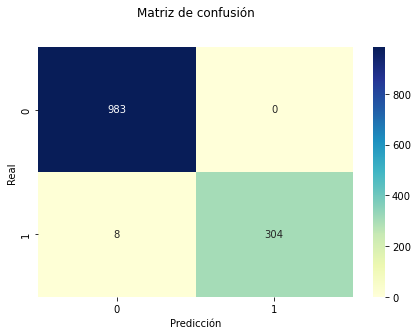

In [23]:
matriz_lr = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(pd.DataFrame(matriz_lr), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [24]:
clas_lr = classification_report(y_test, lr_y_pred, zero_division = 1) #Se toma como referencia el Recall y el F1-score como las métricas de desempeño a evaluar. Debido a que el Accuracy
print(clas_lr)                                                        #y la precisión, si bien son métricas valiosas, pueden presentar resultados engañosos.

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       983
           1       1.00      0.97      0.99       312

    accuracy                           0.99      1295
   macro avg       1.00      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295



In [25]:
rfc = RandomForestClassifier() #Random Forest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [26]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 300}
Mejor estimador RandomForestClassifier(n_estimators=300)


In [27]:
rfc_y_pred = gs_rfc.predict(X_test)
rfc_y_pred
# rfc.fit(X_train,y_train)
# rfc_y_pred = rfc.predict(X_test)
# rfc_y_pred

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Text(0.5, 15.0, 'Predicción')

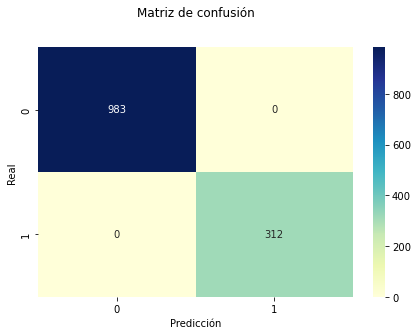

In [28]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)  #Este modelo presenta una predicción perfecta.
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [29]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       983
           1       1.00      1.00      1.00       312

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



In [30]:
svm = SVC()   #Support Vector Machine
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

gs_svm = GridSearchCV(svm, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [31]:
print("Mejores parámetros", gs_svm.best_params_)
print("Mejor estimador", gs_svm.best_estimator_)

Mejores parámetros {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor estimador SVC(C=10, gamma=0.01)


In [32]:
svm_y_pred = gs_svm.predict(X_test)
svm_y_pred
# svm.fit(X_train,y_train)
# svm_y_pred = svm.predict(X_test)
# svm_y_pred

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Text(0.5, 15.0, 'Predicción')

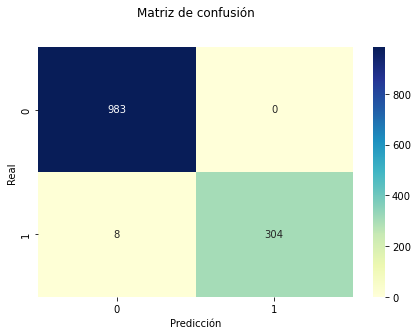

In [33]:
matriz_svm = confusion_matrix(y_test, svm_y_pred)
sns.heatmap(pd.DataFrame(matriz_svm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [34]:
clas_svm = classification_report(y_test, svm_y_pred, zero_division = 1)
print(clas_svm)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       983
           1       1.00      0.97      0.99       312

    accuracy                           0.99      1295
   macro avg       1.00      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295



In [35]:
knn = KNeighborsClassifier()  #K-Nearest Neighbors
param_grid = {
    'n_neighbors': (3, 5, 10),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev', 'euclidean', 'manhattan')
    }
gs_knn = GridSearchCV(knn, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [36]:
print("Mejores parámetros", gs_knn.best_params_)
print("Mejor estimador", gs_knn.best_estimator_)

Mejores parámetros {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mejor estimador KNeighborsClassifier(leaf_size=20, p=1, weights='distance')


In [37]:
knn_y_pred = gs_knn.predict(X_test)
knn_y_pred
# knn.fit(X_train,y_train)
# knn_y_pred = knn.predict(X_test)
# knn_y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Text(0.5, 15.0, 'Predicción')

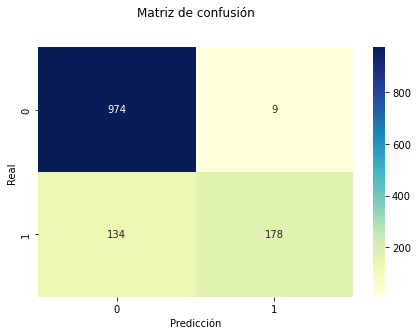

In [38]:
matriz_knn = confusion_matrix(y_test, knn_y_pred)
sns.heatmap(pd.DataFrame(matriz_knn), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [39]:
clas_knn = classification_report(y_test, knn_y_pred, zero_division = 1)
print(clas_knn)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       983
           1       0.95      0.57      0.71       312

    accuracy                           0.89      1295
   macro avg       0.92      0.78      0.82      1295
weighted avg       0.90      0.89      0.88      1295



In [40]:
lda = LinearDiscriminantAnalysis()    #Linear Discriminant Analysis
param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}
gs_lda = GridSearchCV(lda, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [41]:
print("Mejores parámetros", gs_lda.best_params_)
print("Mejor estimador", gs_lda.best_estimator_)

Mejores parámetros {'solver': 'svd', 'tol': 0.0001}
Mejor estimador LinearDiscriminantAnalysis()


In [42]:
lda_y_pred = gs_lda.predict(X_test)
lda_y_pred
# lda.fit(X_train,y_train)
# lda_y_pred = lda.predict(X_test)
# lda_y_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Text(0.5, 15.0, 'Predicción')

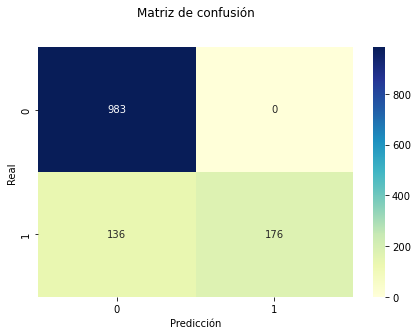

In [43]:
matriz_lda = confusion_matrix(y_test, lda_y_pred)
sns.heatmap(pd.DataFrame(matriz_lda), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [44]:
clas_lda = classification_report(y_test, lda_y_pred, zero_division = 1)
print(clas_lda)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       983
           1       1.00      0.56      0.72       312

    accuracy                           0.89      1295
   macro avg       0.94      0.78      0.83      1295
weighted avg       0.91      0.89      0.88      1295



Al comparar el reporte de las métricas de evaluación de los distintos modelos, encontramos que la Regresión Logística, el Random Forest y el Support Vector Machine tienen resultados muy favorables en la identificación de un cliente con Mora mayor a 30 días; incluso el Random Forest tuvo una predicción perfecta. Sin embargo, se requiere hacer más pruebas con conjuntos de datos más numerosos para identificar si los resultados son óptimos o son resultado de un proceso de sobre-entrenamiento (overfitting). No obstante, el uso de herramientas de Cross Validation como StratifiedKFold, así como la implementación de la función GridSearchCV están orientadas a evitar este tipo de inconvenientes en el proceso de entrenamiento.

In [45]:
print('Regresión Logística', '\n', clas_lr)
print('Random Forest','\n',clas_rfc)
print('Support Vector Machine','\n',clas_svm)
print('K-Nearest Neighbors','\n',clas_knn)
print('Linear Discriminant Analysis','\n',clas_lda)

Regresión Logística 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       983
           1       1.00      0.97      0.99       312

    accuracy                           0.99      1295
   macro avg       1.00      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295

Random Forest 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       983
           1       1.00      1.00      1.00       312

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       983
           1       1.00      0.97      0.99       312

    accuracy                           0.99      1295
   macro avg       1.00      0.99      0.99      1295
weighted av

In [46]:
gs_rfc.best_estimator_.feature_importances_

array([0.90388506, 0.00152379, 0.00412221, 0.00963461, 0.00171726,
       0.00704959, 0.00093322, 0.00256625, 0.00406778, 0.00385642,
       0.00415236, 0.01044343, 0.00736986, 0.00208405, 0.01158323,
       0.00966168, 0.01322635, 0.00212283])

Por último, se hace una evaluación de las variables más importantes, o dicho de otro modo, aquellas que más influyeron en el resultado final. Así, encontramos que por mucha diferencia, la variable más importante es la de 'MoraMax_UltimoSemestre'. Sin embargo, es destacable observar en el tercer lugar la variable Gastos Familiares, seguido de Ingresos; son variables, por tanto, que deben considerarse con mucha atención a la hora de hacer un estudio de crédito.

Text(0.5, 0, 'Random Forest Feature Importance')

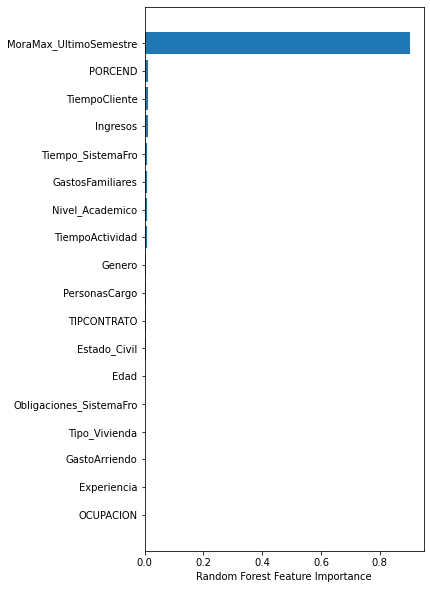

In [47]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = gs_rfc.best_estimator_.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], gs_rfc.best_estimator_.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

Por su parte, al realizar el mismo proceso, pero ahora con la función Permutation Importance, si bien no se modifica el resultado principal, sí aparecen las variables Nivel_Academico y Estado_Civil con un alto grado de relevancia.

Text(0.5, 0, 'Permutation Importance')

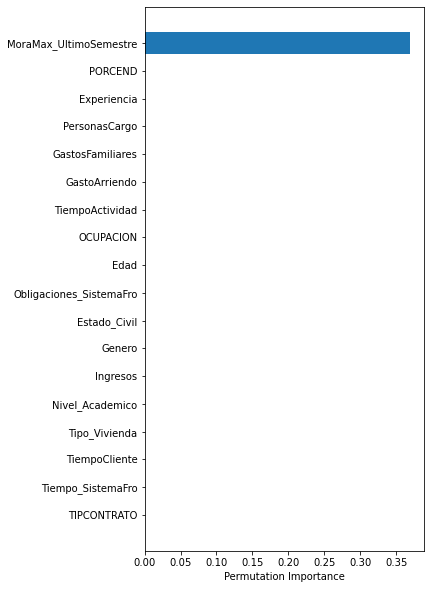

In [48]:
perm_importance = permutation_importance(gs_rfc, X_test, y_test)
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

Ahora bien, después de construido un modelo basado en la variable 'Mora30', se propone hacer lo propio pero ahora tomando los días de Mora máximos como el insumo principal para hacer la predicción. Entre otras cosas, hacerlo de este modo, si bien tiene un impacto en términos de precisión, tiene la ventaja principal de otorgar en tiempo real un perfil de riesgo, en una escala de 1 a 5, que puede ser de gran utilidad a la hora de establecer un cupo. En este sentido, se construyen modelos de clasificación multivariados, y se le entrega una variable Y de 5 clases, determinadas por la mora en una clave de 30 días: 

**Clase 1:** 0-30 días

**Clase 2:** 31-60 días

**Clase 3:** 61-90 días

**Clase 4:** 91-120 días

**Clase 5:** Más de 121 días

In [49]:
Mora = []
for x in datos['MoraMax_UltimoSemestre']:
  if x >= 121:
    Mora.append(5)
  elif x >= 91:
    Mora.append(4)
  elif x >= 61:
    Mora.append(3)
  elif x >= 31:
    Mora.append(2)
  elif x >= 0:
    Mora.append(1)
  else:
    None

In [50]:
datos.insert(20, "Mora", Mora, allow_duplicates=False)
datos.head()

,Mora30,Mora60,MoraMax_UltimoSemestre,Experiencia,PersonasCargo,GastosFamiliares,GastoArriendo,TiempoActividad,OCUPACION,Edad,...,Estado_Civil,Genero,Ingresos,Nivel_Academico,Tipo_Vivienda,TiempoCliente,Tiempo_SistemaFro,PORCEND,Obligaciones_SistemaFro,Mora
1,0,0,0,0,0,7837.87,0,10,1,1,...,0,1,11698.313433,3,2,40,0,1.020685,0,1
2,1,0,59,0,1,9194.07,0,1,0,0,...,0,0,13722.492537,3,0,0,0,0.543829,0,2
3,0,0,30,1,1,8450.00,0,1,0,0,...,0,1,12611.940299,0,2,13,73,0.946746,0,1
4,1,0,47,0,0,7472.00,0,1,0,0,...,3,1,11152.238806,4,1,1,0,0.936831,0,2
5,0,0,0,0,0,6160.00,0,2,0,0,...,3,1,9194.029851,4,1,0,0,0.487013,0,1


Se imprimen los datos agrupados por las clases para obervar el balance entre las mismas. Se observa un desbalance importante, especialmente entre la clase 1 y el resto. La clase 4, al tener menor cantidad de personas, se intuye como la más complicada de predecir, ya se verá que tan bien se desempeñan los modelos en su predicción.

In [51]:
print(datos.groupby('Mora').size())

Mora
1    3264
2     547
3     239
4      91
5     174
dtype: int64


In [52]:
X = np.array(datos.drop(['Mora30','Mora60','Mora'],1))
Y = np.array(datos['Mora'])
feature_names = datos.drop(['Mora30','Mora60','Mora'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

C:\Users\jlope\AppData\Local\Temp/ipykernel_3616/3788078937.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\jlope\AppData\Local\Temp/ipykernel_3616/3788078937.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



array(['MoraMax_UltimoSemestre', 'Experiencia', 'PersonasCargo',
       'GastosFamiliares', 'GastoArriendo', 'TiempoActividad',
       'OCUPACION', 'Edad', 'TIPCONTRATO', 'Estado_Civil', 'Genero',
       'Ingresos', 'Nivel_Academico', 'Tipo_Vivienda', 'TiempoCliente',
       'Tiempo_SistemaFro', 'PORCEND', 'Obligaciones_SistemaFro'],
      dtype=object)

In [53]:
X = pd.DataFrame(X, columns=feature_names)

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [55]:
escalar = StandardScaler(with_mean=False)
X_train = escalar.fit_transform(X_train)
X_test = escalar.transform(X_test)

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [57]:
params = {
    'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': np.linspace(0.00002,1,100)
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlope\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


C:\Users\jlope\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning:

Estimator fit failed. The score 

In [58]:
print("Mejores parámetros", lr_gs.best_params_)
print("Mejor estimador", lr_gs.best_estimator_)

Mejores parámetros {'C': 0.9494959595959596, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor estimador LogisticRegression(C=0.9494959595959596, penalty='l1', solver='liblinear')


In [59]:
lr_y_pred = lr_gs.predict(X_test)
lr_y_pred

# lr.fit(X_train,y_train)
# lr_y_pred = lr.predict(X_test)
# lr_y_pred

array([1, 1, 2, ..., 5, 1, 2], dtype=int64)

Text(0.5, 15.0, 'Predicción')

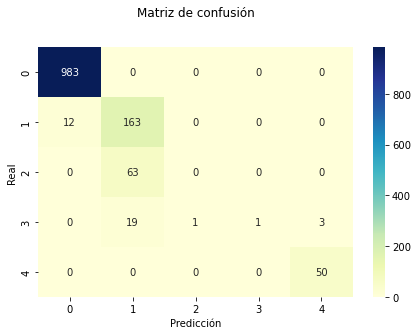

In [60]:
plt.rcParams["figure.figsize"] = (6, 4)
matriz_lr = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(pd.DataFrame(matriz_lr), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [61]:
clas_lr = classification_report(y_test, lr_y_pred, zero_division = 1)
print(clas_lr)

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       983
           2       0.67      0.93      0.78       175
           3       0.00      0.00      0.00        63
           4       1.00      0.04      0.08        24
           5       0.94      1.00      0.97        50

    accuracy                           0.92      1295
   macro avg       0.72      0.59      0.56      1295
weighted avg       0.89      0.92      0.90      1295



In [62]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [63]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 100}
Mejor estimador RandomForestClassifier()


In [64]:
rfc_y_pred = gs_rfc.predict(X_test)
rfc_y_pred
# rfc.fit(X_train,y_train)
# rfc_y_pred = rfc.predict(X_test)
# rfc_y_pred

array([1, 1, 2, ..., 5, 1, 2], dtype=int64)

Text(0.5, 15.0, 'Predicción')

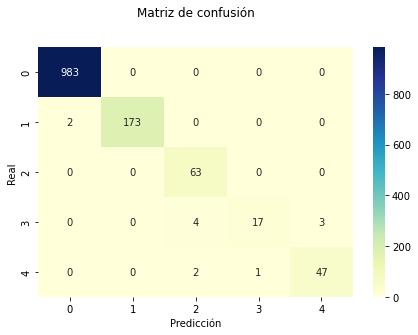

In [65]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [66]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       983
           2       1.00      0.99      0.99       175
           3       0.91      1.00      0.95        63
           4       0.94      0.71      0.81        24
           5       0.94      0.94      0.94        50

    accuracy                           0.99      1295
   macro avg       0.96      0.93      0.94      1295
weighted avg       0.99      0.99      0.99      1295



In [67]:
svm = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

gs_svm = GridSearchCV(svm, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [68]:
print("Mejores parámetros", gs_svm.best_params_)
print("Mejor estimador", gs_svm.best_estimator_)

Mejores parámetros {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Mejor estimador SVC(C=1000, gamma=0.0001)


In [69]:
svm_y_pred = gs_svm.predict(X_test)
svm_y_pred
# svm.fit(X_train,y_train)
# svm_y_pred = svm.predict(X_test)
# svm_y_pred

array([1, 1, 2, ..., 5, 1, 2], dtype=int64)

Text(0.5, 15.0, 'Predicción')

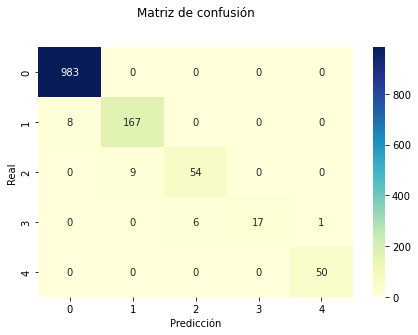

In [70]:
matriz_svm = confusion_matrix(y_test, svm_y_pred)
sns.heatmap(pd.DataFrame(matriz_svm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [71]:
clas_svm = classification_report(y_test, svm_y_pred, zero_division = 1)
print(clas_svm)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       983
           2       0.95      0.95      0.95       175
           3       0.90      0.86      0.88        63
           4       1.00      0.71      0.83        24
           5       0.98      1.00      0.99        50

    accuracy                           0.98      1295
   macro avg       0.96      0.90      0.93      1295
weighted avg       0.98      0.98      0.98      1295



In [72]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': (3, 5, 10),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev', 'euclidean', 'manhattan')
    }
gs_knn = GridSearchCV(knn, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [73]:
print("Mejores parámetros", gs_knn.best_params_)
print("Mejor estimador", gs_knn.best_estimator_)

Mejores parámetros {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Mejor estimador KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')


In [74]:
knn_y_pred = gs_knn.predict(X_test)
knn_y_pred
# knn.fit(X_train,y_train)
# knn_y_pred = knn.predict(X_test)
# knn_y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

Text(0.5, 15.0, 'Predicción')

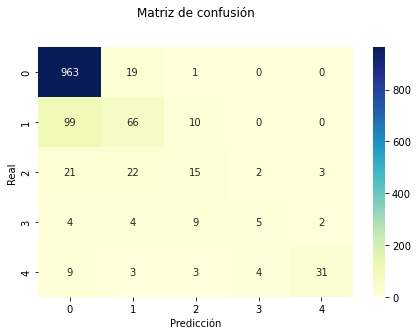

In [75]:
matriz_knn = confusion_matrix(y_test, knn_y_pred)
sns.heatmap(pd.DataFrame(matriz_knn), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [76]:
clas_knn = classification_report(y_test, knn_y_pred, zero_division = 1)
print(clas_knn)

              precision    recall  f1-score   support

           1       0.88      0.98      0.93       983
           2       0.58      0.38      0.46       175
           3       0.39      0.24      0.30        63
           4       0.45      0.21      0.29        24
           5       0.86      0.62      0.72        50

    accuracy                           0.83      1295
   macro avg       0.63      0.48      0.54      1295
weighted avg       0.81      0.83      0.81      1295



In [77]:
lda = LinearDiscriminantAnalysis()
param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}
gs_lda = GridSearchCV(lda, param_grid, cv=skf, verbose=1).fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [78]:
print("Mejores parámetros", gs_lda.best_params_)
print("Mejor estimador", gs_lda.best_estimator_)

Mejores parámetros {'solver': 'svd', 'tol': 0.0001}
Mejor estimador LinearDiscriminantAnalysis()


In [79]:
lda_y_pred = gs_lda.predict(X_test)
lda_y_pred
# lda.fit(X_train,y_train)
# lda_y_pred = lda.predict(X_test)
# lda_y_pred

array([1, 1, 2, ..., 5, 1, 2], dtype=int64)

Text(0.5, 15.0, 'Predicción')

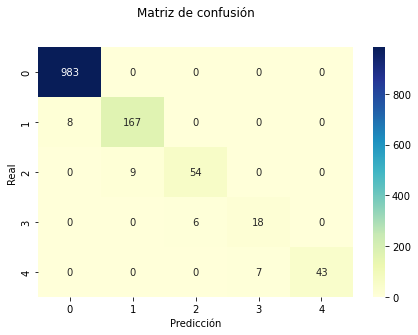

In [80]:
matriz_lda = confusion_matrix(y_test, lda_y_pred)
sns.heatmap(pd.DataFrame(matriz_lda), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [81]:
clas_lda = classification_report(y_test, lda_y_pred, zero_division = 1)
print(clas_lda)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       983
           2       0.95      0.95      0.95       175
           3       0.90      0.86      0.88        63
           4       0.72      0.75      0.73        24
           5       1.00      0.86      0.92        50

    accuracy                           0.98      1295
   macro avg       0.91      0.88      0.90      1295
weighted avg       0.98      0.98      0.98      1295



Teniendo en cuenta que al construir modelos con una mayor de cantidad de clases implica un impacto importante en términos de precisión de la predicción, se observan resultados muy satisfactorios en dos de los modelos: Random Forest y Support Vector Machine. Ello porque incluso considerando que las clases tienen un desbalance importante, las métricas asociadas con Macro avg presentan buenos resultados, aún cuando esta métrica penaliza mucho dicho desbalance. Así pues, lo que define cuál de los dos modelos es mejor es la predicción de las tres últimas clases, en especial la clase 4. Sin embargo, si bien la predicción de esta clase tuvo un mejor desempeño en el modelo SVM, en la generalidad del modelo (y en la predicción de las otras clases) se termina imponiendo el rendimiento del Random Forest. Además, en las primeras clases, que son las más importantes para el presente problema (Asignación de un producto de alta gama), la predicción de este modelo es perfecta, mientras en los demás, los Falsos Positivos presentados se dieron entre ellas mismas; es decir, no tenemos predicciones en donde un cliente con mal historial de pago haya sido presentado como un cliente con buen historial.

In [82]:
print('Regresión Logística', '\n', clas_lr)
print('Random Forest','\n',clas_rfc)
print('Support Vector Machine','\n',clas_svm)
print('K-Nearest Neighbors','\n',clas_knn)
print('Linear Discriminant Analysis','\n',clas_lda)

Regresión Logística 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99       983
           2       0.67      0.93      0.78       175
           3       0.00      0.00      0.00        63
           4       1.00      0.04      0.08        24
           5       0.94      1.00      0.97        50

    accuracy                           0.92      1295
   macro avg       0.72      0.59      0.56      1295
weighted avg       0.89      0.92      0.90      1295

Random Forest 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       983
           2       1.00      0.99      0.99       175
           3       0.91      1.00      0.95        63
           4       0.94      0.71      0.81        24
           5       0.94      0.94      0.94        50

    accuracy                           0.99      1295
   macro avg       0.96      0.93      0.94      1295
weighted avg       0.99      0.99      

En términos de Importancia de las variables, se mantiene la tendencia donde los Gastos Familiares y los Ingresos suponen alta relevancia para el modelo, a comparación del resto de variables.

Text(0.5, 0, 'Random Forest Feature Importance')

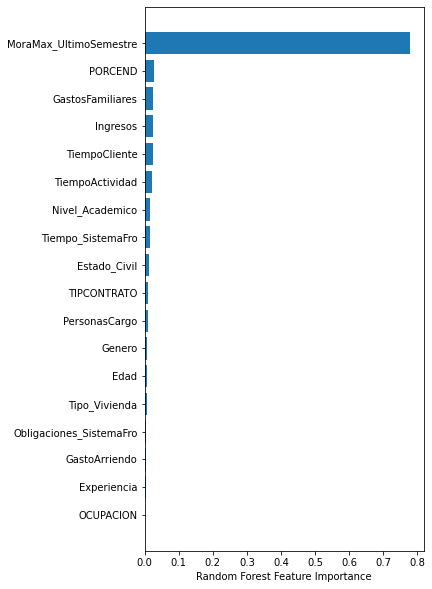

In [83]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = gs_rfc.best_estimator_.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], gs_rfc.best_estimator_.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Permutation Importance')

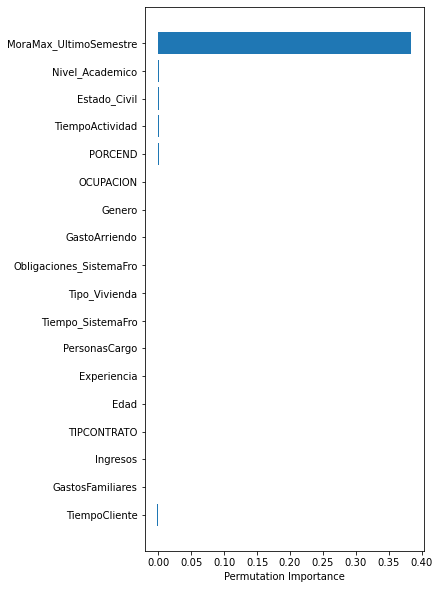

In [84]:
perm_importance = permutation_importance(gs_rfc, X_test, y_test)
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

En lo referente al Análisis de los modelos propuestos a la compañía para la clasificación de clientes, si bien no existe la información suficiente para dar un veredicto más informado, se realiza un estudio descriptivo para justificar la conclusión a la que se llegó.

In [85]:
datos = pd.read_excel(r"C:\Users\jlope\Documents\Prueba_tecnica_Tuya\ModelosCompetencia.xlsx")
datos = datos.drop(columns=['ID','Fecha Estudio'])
datos.index = np.arange(1, len(datos) + 1)
datos.head()

,PuntajeAB,PuntajeXY,Default
1,10.956522,23.382353,0
2,10.956522,.,1
3,10.913043,25.705882,0
4,10.086957,22.735294,0
5,9.217391,19.470588,1


In [86]:
datos.nunique()

PuntajeAB    132
PuntajeXY    739
Default        2
dtype: int64

In [87]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114109 entries, 1 to 114109
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   PuntajeAB  114109 non-null  float64
 1   PuntajeXY  114109 non-null  object 
 2   Default    114109 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ MB


De ser necesario elegir uno de estos dos modelos, la recomendación es que sea el ModeloAB. Esto varias razones: En primer lugar, al observar el conjunto de datos y su relación con la variable de inclumplimiento ('Default'), se ecuentra que en 12800 casos, el ModeloXY no otorgó calificación alguna, a diferencia del ModeloAB. Además, revisando las gráficas presentadas a continuación, el espectro de los puntajes en el ModeloXY es mucho más grande y disperso, lo cual representa un aspecto negativo en el despliegue del modelo en términos de precisión, y además se traduce en una mayor varianza en los resultados del modelo. El ModeloAB, por su parte, tiene los resultados más concentrados en una escala mejor definida, y ello le daría una mayor precisión en el despliegue del modelo. 

In [88]:
Default0 = datos[datos['Default']==0]
Default1 = datos[datos['Default']==1]

barra0 = go.Bar(
            x = Default0["PuntajeAB"].value_counts().index.values,
            y = Default0["PuntajeAB"].value_counts().values,
            name='Sin Mora')

barra1 = go.Bar(
            x = Default1["PuntajeAB"].value_counts().index.values,
            y = Default1["PuntajeAB"].value_counts().values,
            name='Con Mora')

data = [barra0, barra1]

fig = plot.subplots.make_subplots(rows=1, cols=2, subplot_titles=('Sin Default','Con Default'))

fig.append_trace(barra0, 1, 1)
fig.append_trace(barra1, 1, 2)

fig['layout'].update(showlegend=True, yaxis=dict(
        title='Frecuencia'
    ),
    title='Modelo AB', bargap=0.05)

py.iplot(fig, filename='ModeloAB')
# fig.show(renderer='colab') #Este código es necesario para la visualización en Google Colab

In [89]:
barra2 = go.Bar(
            x = Default0["PuntajeXY"].value_counts().index.values,
            y = Default0["PuntajeXY"].value_counts().values,
            name='Sin Mora')

barra3 = go.Bar(
            x = Default1["PuntajeXY"].value_counts().index.values,
            y = Default1["PuntajeXY"].value_counts().values,
            name='Con Mora')


data = [barra2, barra3]

fig = plot.subplots.make_subplots(rows=1, cols=2, subplot_titles=('Sin Default','Con Default'))

fig.append_trace(barra2, 1, 1)
fig.append_trace(barra3, 1, 2)

fig['layout'].update(showlegend=True, yaxis=dict(
        title='Frecuencia'
    ),
    title='Modelo XY', bargap=0.05)

py.iplot(fig, filename='ModeloXY')
# fig.show(renderer='colab')  #Este código es necesario para la visualización en Google Colab